<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture #25

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import scipy.integrate as ig

##In our last episode

* Digital signal processing
  * Time series of regularly spaced measurements
  * $\{f_n\} \to  H \to  \{f'_n\}$
  * Convolution $f * g$: effect of a resolution function on input signal
  * Correlation between $f$ and $g$: finding time shifts between signals
  * Evaluation of integrals takes ages, need a different approach: Fourier transform
  

##Signal processing and analysis

### Motivation

__Signals__ 

For our purposes, a _signal_ is a sequence of $N$ measurements ("samplings") of some quantity $f$, usually at different times $t$: 

$$\{f_n\} = \{f_0,f_1,\dots,f_{N-1}\}$$

__ Convolution and Correlation __

Consider the case in which we have two signals $f(t)$ and $g(t)$. The _convolution_ of the two is:

$$ f*g = \int_{-\infty}^{+\infty} g(\tau)f(t-\tau) d\tau $$

Here's an example, in which the function $g(t)$ is a normal distribution (potentially a good model for detector resolution/smearing) and $f(t)$ has narrow spikes. The resulting convolution spreads out the spikes, leaving their location intact (since $f,g$ are symmetric).  

The _correlation_ of two signals is similar:

$$ C(t) = \int_{-\infty}^{+\infty} g(\tau+t)f(\tau) d\tau $$

###Fourier Transforms

__Fourier's Theorem__

_Every reasonably continuous function $f(t)$ can be expressed as a sum, perhaps infinite, of sine and cosine functions with different frequencies $\omega=2\pi f$._  Closely related is the _Fourier transform_

$$f(t) = \int_{-\infty}^{+\infty} F(\omega) e^{i\omega t} \frac{\mathrm{d}\omega}{2\pi}$$

$F(\omega)$ is the "frequency domain" representation of the "time domain" function f(t).  There is an inverse transform:

$$F(\omega)=\int_{-\infty}^{+\infty} f(t) e^{-i\omega t} \mathrm{d}t$$

$f(t)$ and $F(\omega)$ are equally valid ways of looking at the function. It will turn out that understanding and manipulating signals is often best done in the frequency domain. Examples:

* Perhaps my detector is an antenna and the nearby interaction of a hypothesized new particle would create an electro-magnetic wave with a particular frequency (or tone). This might not stand out in the time domain, but would show up as a peak in the frequency domain (if "loud" enough).

* Perhaps I have some 60Hz noise messing with my experiment. I could transform to the frequency domain, mask out the region around 60Hz, then translate back to the time domain.


0n a computer we can calculate a discretized version of the Fourier transform (DFT) which is not only useful for converting to and from the frequency domain, but can also be used to implement correlations and covariances.  In particular, a clever, efficient version of the DFT, called the Fast Fourier Transform (FFT) makes many problems especially tractable with Fourier methods. 

Note: The relation between $t$ and $w$ is a bit like the relation between $x$ and $p$ in quantum mechanics. They are _conjugate variables_, related by the Fourier transform. 

###Example: exponential decay

Consider an exponential decay:

$$f(t)=e^{-at} \quad 0<t<\infty \quad \mbox{and zero elsewhere}.$$ 

The Fourier transform is:

\begin{align}
F(\omega) &= \int_{0}^{+\infty} e^{-at} e^{-i\omega t}\mathrm{d}t \\
 &= \frac{-1}{a+i\omega} e^{-(a+\omega t)} \Big|^\infty_0 \\
 &= \frac{1}{a+i\omega}
 \end{align}
 
Note, the frequency domain is complex, even though the time domain is real. That is generally true. We can describe the complex number in terms of a real and imaginary part:

$$ F(\omega) = \frac{a-i\omega}{a^2+\omega^2}$$

or in terms of a magnitude and phase ($\phi$):

$$ F(\omega)=|F(\omega)| e^{i\phi} $$

with 

$$|F(\omega)|=\frac{1}{\sqrt{a^2+\omega^2}}$$ 

and 

$$\phi=\arctan\frac{\Im\{F(\omega)\}}{\Re\{F(\omega)\}}=\arctan\frac{\omega}{a}$$

We plot $f(t)$ and $F(\omega)$ below.

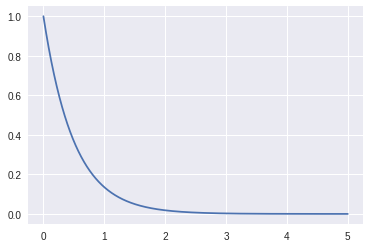

In [0]:
fexp = lambda t,a: np.exp(-a*t)
Fexp = lambda w,a: 1 / (a + 1J*w)

framerate = 44100

a = 2

t = np.linspace(0, 5, 5*framerate)
plt.plot(t, fexp(t,a))

In [0]:
Audio(fexp(t,a), rate = framerate, autoplay = True)

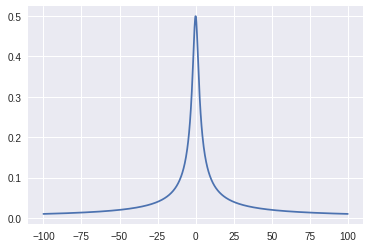

In [0]:
w = np.linspace(-200/a, 200/a, 1000)
plt.plot(w, np.absolute(Fexp(w, a)))

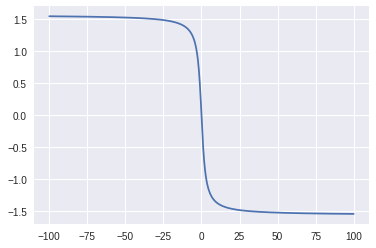

In [0]:
plt.plot(w, np.angle(Fexp(w, a)))

### Example: sinusoidal signals

Consider a sinusoidal signal:

$$f(t)=\sin{\omega_0 t} = \frac{1}{2 i} \big( e^{i\omega_0 t} - e^{-i\omega_0 t} \big).$$ 

The Fourier transform is:

\begin{align}
F(\omega) &= \int_{-\infty}^{+\infty} \frac{1}{2 i} \big( e^{i\omega_0 t} - e^{-i\omega_0 t} \big)  e^{-i\omega t}\mathrm{d}t \\
 &= \frac{1}{2 i} \Big( e^{- i (\omega-\omega_0) t} - e^{- i (\omega + \omega_0) t} \Big) \Big|^{+\infty}_{-\infty} \\
 &= \frac{1}{2} \big( \delta(\omega-\omega_0) - \delta(\omega+\omega_0) \big)
 \end{align}
 
 This means that the Fourier transform of a perfect sine wave will only have non-zero values at the frequencies $\pm\omega_0$.
 
 Since the function $\delta(\omega - \omega_0)$ is infinite at $\omega_0$ we cannot represent it in our finite python objects. Still, this helps us understand what's going one: large values at specific frequencies indicate that signal has a lot of strength in those frequencies!

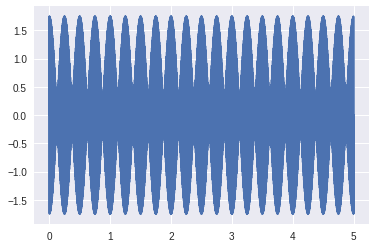

In [0]:
gexp = lambda t,A1,f1,A2,f2: A1 * np.sin(2.0*np.pi*f1*t) + A2 * np.sin(2.0*np.pi*f2*t)
def Gexp (w,A1,f1,A2,f2):
  G = np.zeros_like(w)
  width = w[1] - w[0]
  G[np.fabs(w - 2.0*np.pi*f1) <= width] = -A1/2/width
  G[np.fabs(w + 2.0*np.pi*f1) <= width] = +A1/2/width
  G[np.fabs(w - 2.0*np.pi*f2) <= width] = -A2/2/width
  G[np.fabs(w + 2.0*np.pi*f2) <= width] = +A2/2/width
  return G

framerate = 44100

A1 = 1
f1 = 220.0
A2 = 0.75
f2 = 224.0

t = np.linspace(0, 5, framerate*5)
plt.plot(t, gexp(t,A1,f1,A2,f2))

In [0]:
Audio(gexp(t,A1,f1,A2,f2), rate = framerate, autoplay = True)

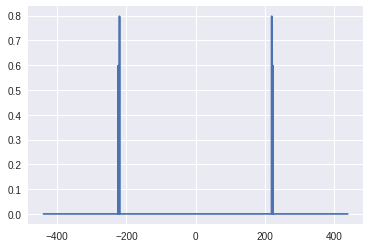

In [0]:
f = np.linspace(-2*f1, +2*f1, framerate//5)
w = 2.0*np.pi*f
plt.plot(f, np.absolute(Gexp(w, A1, f1, A2, f2)))

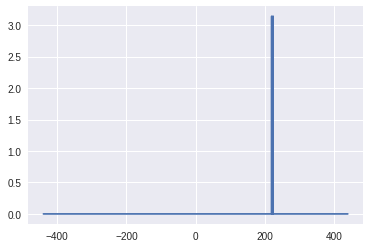

In [0]:
plt.plot(f, np.angle(Gexp(w, A1,f1,A2,f2)))

##The Discrete Fourier Transform - DFT

###Computing a DFT using FFTpack

signal duration = 5 sec
number of samples = 220500
sampling period (delta t) = 2.2675736961451248e-05 sec
sampling frequency = 44100.0


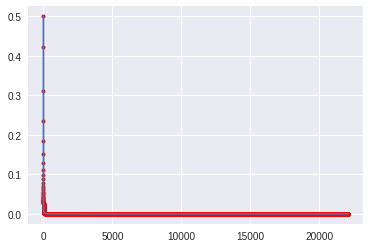

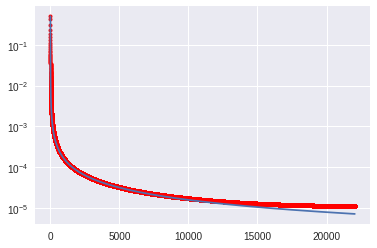

In [0]:
import scipy.fftpack as fft

T = 5 # duration
N = T*framerate # N samples
t = np.linspace(0,T,N)

fs = N/T
ws = 2*math.pi*fs

print("signal duration =", T, "sec")
print("number of samples =", N)
print("sampling period (delta t) =", T/N, "sec")
print("sampling frequency =", fs)

samples = fexp(t,a)
FFTexp = fft.fft(samples)

f_FFT = np.linspace(0,fs/2,N//2+1)
w_FFT = np.linspace(0,ws/2,N//2+1)

f_exp = np.linspace(0,fs/2,framerate)
w_exp = np.linspace(0,ws/2,framerate)

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.plot(f_exp, np.absolute(Fexp(w_exp,a)))
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.semilogy(f_exp, np.absolute(Fexp(w_exp,a)))
plt.show()

signal duration = 5 sec
number of samples = 220500
sampling period (delta t) = 2.2675736961451248e-05 sec
sampling frequency = 44100.0


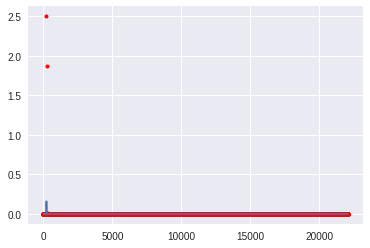

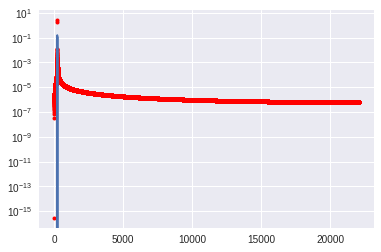

In [0]:
T = 5 # duration
N = T*framerate # N samples
t = np.linspace(0,T,N)

fs = N/T
ws = 2*math.pi*fs

print("signal duration =", T, "sec")
print("number of samples =", N)
print("sampling period (delta t) =", T/N, "sec")
print("sampling frequency =", fs)

samples = gexp(t,A1,f1,A2,f2)
FFTexp = fft.fft(samples)

f_FFT = np.linspace(0,fs/2,N//2+1)
w_FFT = np.linspace(0,ws/2,N//2+1)

f_exp = np.linspace(0,fs/2,framerate)
w_exp = np.linspace(0,ws/2,framerate)

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.plot(f_exp, np.absolute(Gexp(w_exp,A1,f1,A2,f2)))
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.semilogy(f_exp, np.absolute(Gexp(w_exp,A1,f1,A2,f2)))
plt.show()

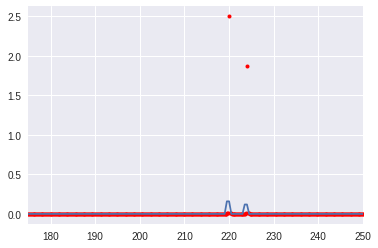

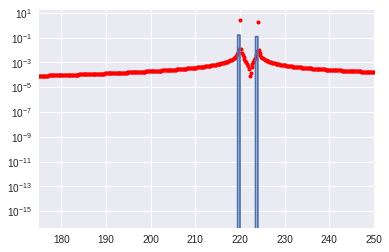

In [0]:
plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.plot(f_exp, np.absolute(Gexp(w_exp,A1,f1,A2,f2)))
plt.xlim(175, 250)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.semilogy(f_exp, np.absolute(Gexp(w_exp,A1,f1,A2,f2)))
plt.xlim(175, 250)
plt.show()

### High/Low pass filters

In [0]:
from scipy.io import wavfile

! wget -N 'https://github.com/paulgclark/laurel-yanny/raw/master/yanny-or-laurel.wav'

# Load the file on an object
data = wavfile.read("yanny-or-laurel.wav")

--2018-11-07 17:37:53--  https://github.com/paulgclark/laurel-yanny/raw/master/yanny-or-laurel.wav
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/paulgclark/laurel-yanny/master/yanny-or-laurel.wav [following]
--2018-11-07 17:37:53--  https://raw.githubusercontent.com/paulgclark/laurel-yanny/master/yanny-or-laurel.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1088790 (1.0M) [audio/wav]
Saving to: ‘yanny-or-laurel.wav’

yanny-or-laurel.wav 100%[===================>]   1.04M  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2018-11-07 17:37:53 (

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [0]:
# Separete the object elements
framerate = data[0]
sounddata = data[1][:,0] # only pick left channel
time      = np.arange(0, len(sounddata)) / framerate

# Show information about the object
print('Sample rate:', framerate, 'Hz')
print('Total time:', len(sounddata) / framerate, 's')

Sample rate: 44100 Hz
Total time: 6.156643990929705 s


In [0]:
# Print the samples
print(sounddata)

[10 12 14 ... -5 -6 -8]


In [0]:
# Play the wave file
from IPython.display import Audio
Audio(sounddata, rate = framerate, autoplay = True)

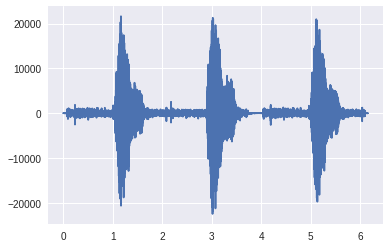

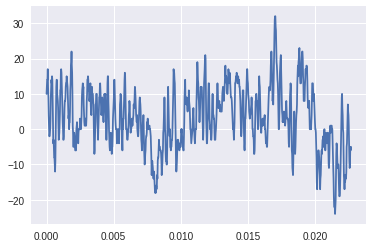

In [0]:
# Plot the samples
plt.plot(time, sounddata)
plt.show()
plt.plot(time[:1000], sounddata[:1000])

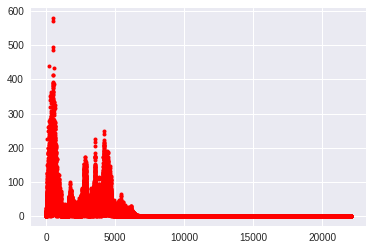

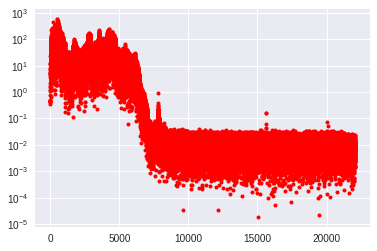

In [0]:
# Forward FFT

T = time[-1] # duration
N = len(sounddata) # N samples
fs = N/T
ws = 2*math.pi*fs

freq = np.linspace(0,fs/2,N//2+1)

FFTexp = fft.fft(sounddata)

f_FFT = np.linspace(0,fs/2,N//2+1)
w_FFT = np.linspace(0,ws/2,N//2+1)

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.show()

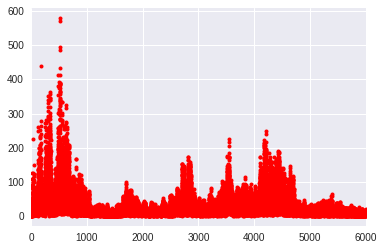

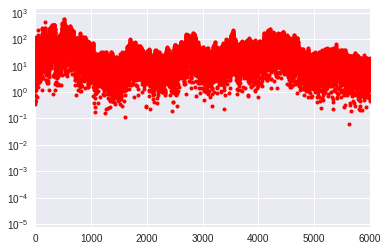

In [0]:
plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.xlim(0,6000)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[0:N//2+1]), "or", ms = 4)
plt.xlim(0,6000)
plt.show()

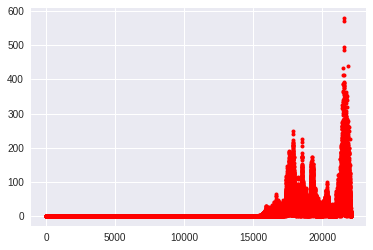

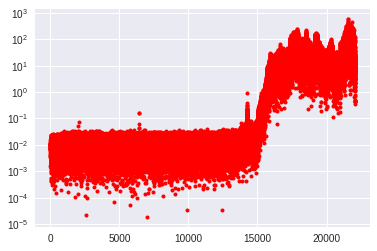

In [0]:
plt.plot(f_FFT, (T/N)*np.absolute(FFTexp[N//2-1:]), "or", ms = 4)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp[N//2-1:]), "or", ms = 4)
plt.show()

#### Inverse Fourier transform back to time domain

In [0]:
sounddata_reconstructed = fft.ifft(FFTexp)
Audio(sounddata_reconstructed, rate = framerate, autoplay = True)

/usr/local/lib/python3.6/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [0]:
np.sum(np.absolute(sounddata - sounddata_reconstructed))

0.0002804231588810797

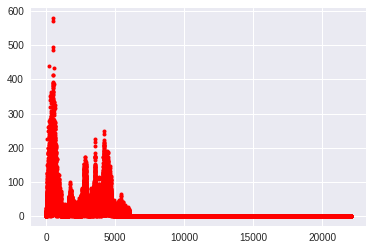

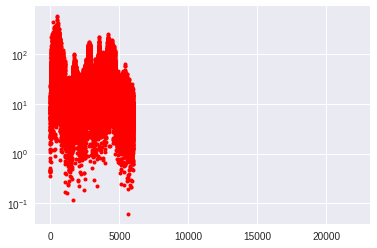

In [0]:
FFTexp2 = np.array(FFTexp)
cutoff = len(freq[freq < 6000])
FFTexp2[cutoff:] = 0

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp2[0:N//2+1]), "or", ms = 4)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp2[0:N//2+1]), "or", ms = 4)
plt.show()

In [0]:
sounddata2 = fft.ifft(FFTexp2)
Audio(sounddata2, rate = framerate, autoplay = True)

/usr/local/lib/python3.6/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [0]:
np.absolute(np.sum(sounddata - sounddata2))

1.3087363302189497e-09

What happens if we apply a low pass filter below 1500 Hz?

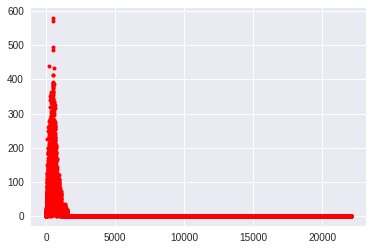

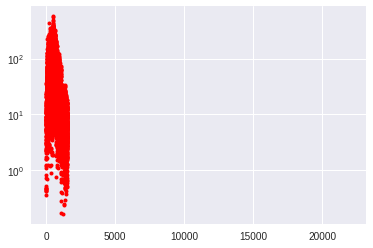

In [0]:
FFTexp3 = np.array(FFTexp)
cutoff = len(freq[freq < 1500])
FFTexp3[cutoff:] = 0

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp3[0:N//2+1]), "or", ms = 4)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp3[0:N//2+1]), "or", ms = 4)
plt.show()

In [0]:
sounddata3 = fft.ifft(FFTexp3)
Audio(sounddata3, rate = framerate, autoplay = True)

/usr/local/lib/python3.6/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


What happens if we apply a high pass filter above 1500 Hz?

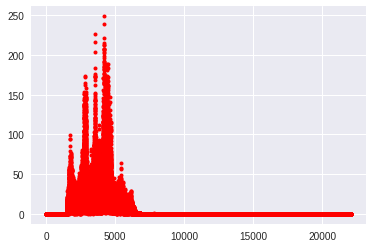

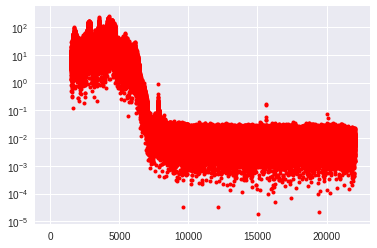

In [0]:
FFTexp4 = np.array(FFTexp)
cutoff = len(freq[freq < 1500])
FFTexp4[:cutoff] = 0

plt.plot(f_FFT, (T/N)*np.absolute(FFTexp4[0:N//2+1]), "or", ms = 4)
plt.show()

plt.semilogy(f_FFT, (T/N)*np.absolute(FFTexp4[0:N//2+1]), "or", ms = 4)
plt.show()

In [0]:
sounddata4 = fft.ifft(FFTexp4)
Audio(sounddata4, rate = framerate, autoplay = True)

/usr/local/lib/python3.6/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
